<a href="https://colab.research.google.com/github/Shyamsundarkanaka/Rossmann-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [141]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading the data set and Overview

In [143]:
#Loading the data set
path = '/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data/Rossmann Stores Data.csv')
df_meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data science/Capstone Projects/Retail Sales Prediction - Shyam Sundar K/Data/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
print(df.shape)
print(df_meta.shape)

(1017209, 9)
(1115, 10)


In [145]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [146]:
df_meta

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [148]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [149]:
#checking the null values for main dataset
df.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [150]:
#checking the null vaues for meta data
df_meta.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [151]:
# sorting the data
df = df.sort_values('Date')

In [152]:
df.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2014-01-29,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [153]:
df_meta.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [154]:
df_meta.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [155]:
df_meta.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


In [156]:
df_meta[df_meta.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## We can see that there are 2 data sets, main data of over a million rows which has data or 1115 stores and there is one more data set that gives information for each of these store

##Data Cleaning

In [157]:
#taking a backup for meta data before cleaning
df_meta_backup = df_meta.copy()

In [158]:
df_meta.CompetitionOpenSinceYear.mean()

2008.6688567674114

In [159]:
# Checking the percentage of shops open before 2013
df_meta[df_meta.CompetitionOpenSinceYear >2013].shape[0]/df_meta[df_meta.CompetitionOpenSinceYear <2013].shape[0]

0.18947368421052632

In [160]:
df_meta[df_meta.CompetitionOpenSinceYear >2014].shape

(38, 10)

In [161]:
#Droping the rows 'CompetitionOpenSinceYear','CompetitionOpenSinceMonth'
df_meta.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],axis=1,inplace=True)

### We can see there are lot of null values in competetion open since Year, and for available data we can more than 80% of the competitors open before 2013, and we are doing analysis for sales after 2013, we will drop the columns CompetitionOpenSinceYear and CompetitionOpenSinceMonth

In [162]:

df_meta[df_meta.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [163]:
# Fillng the null values
df_meta.CompetitionDistance.fillna(value = df_meta.CompetitionDistance.mean(), inplace = True)

In [164]:
df_meta.CompetitionDistance.isnull().sum()

0

### Filling the 3 missing values in competetion distance by mean value of the column.

In [165]:
df_meta[df_meta.Promo2==0].isna().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek        544
Promo2SinceYear        544
PromoInterval          544
dtype: int64

In [166]:
df_meta.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [167]:
type(df.Date.max())

str

In [168]:
df.Date = pd.to_datetime(df.Date)
print(df.Date.max())
print(df.Date.max().year)
print(df.Date.max().week)

2015-07-31 00:00:00
2015
31


In [169]:
df_meta.Promo2SinceYear.fillna(value = (df.Date.max().year),inplace=True)
df_meta.Promo2SinceWeek.fillna(value = (df.Date.max().week),inplace=True)
df_meta.isnull().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek          0
Promo2SinceYear          0
PromoInterval          544
dtype: int64

### We are filling null of the promo2 date after the latest day of the available data. It is done as it makes it easy for us to check if the promotion was active while merging the datasets.

In [170]:
df_meta.PromoInterval.fillna(value = 'None',inplace=True)

### We are filling null of the promoInterval with None which will be used for one hot encoding once the datasets are merged.

In [171]:
import datetime
from dateutil.relativedelta import relativedelta

def get_date(year,week):
  year = int(year)
  week = int(week)
  date = datetime.date(year, 1, 1) + relativedelta(weeks=+week)
  return(date)

In [172]:
# Creating a date column using 'Promo2SinceWeek','Promo2SinceYear' columns
df_meta['promo2_start_date'] = df_meta.apply(lambda x: get_date(x.Promo2SinceYear,x.Promo2SinceWeek),axis=1)


In [173]:
# We can drop the 3 columns has we have creted a new columns of promo2_start_date
df_meta.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear'],axis=1,inplace=True)

### 'Promo2','Promo2SinceWeek','Promo2SinceYear' are merged as one promo2_start_date. Now the data set is ready to be merged.

In [174]:
df_meta

,Store,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date
0,1,c,a,1270.0,None,2015-08-06
1,2,a,a,570.0,"Jan,Apr,Jul,Oct",2010-04-02
2,3,a,a,14130.0,"Jan,Apr,Jul,Oct",2011-04-09
3,4,c,c,620.0,None,2015-08-06
4,5,a,a,29910.0,None,2015-08-06
...,...,...,...,...,...,...
1110,1111,a,a,1900.0,"Jan,Apr,Jul,Oct",2013-08-06
1111,1112,c,c,1880.0,None,2015-08-06
1112,1113,a,c,9260.0,None,2015-08-06
1113,1114,a,c,870.0,None,2015-08-06


# Merging Data sets

In [175]:
#taking a backup of main dataset
df_backup = df.copy()

In [176]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1


In [177]:
#merging the meta data with main dataset
df = pd.merge(df, df_meta, on='Store', how='left')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,2015-08-06
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,2015-08-06
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",2010-05-07
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,2015-08-06


In [178]:
#convertiung the datatype to data wherever necessary
df.Date = pd.to_datetime(df.Date)
df.promo2_start_date = pd.to_datetime(df.promo2_start_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [179]:
#Create a new column for promo active or not
df['Promo2_active'] = np.where(df['Date'] >= df['promo2_start_date'], 1 , 0)



In [180]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,2015-08-06,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,2015-08-06,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",2010-05-07,1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,2015-08-06,0


In [181]:
#Droping the promo2 start date column
df.drop(columns = ['promo2_start_date'], axis=1,inplace= True)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

# EDA

In [183]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0


2013
2014
2015


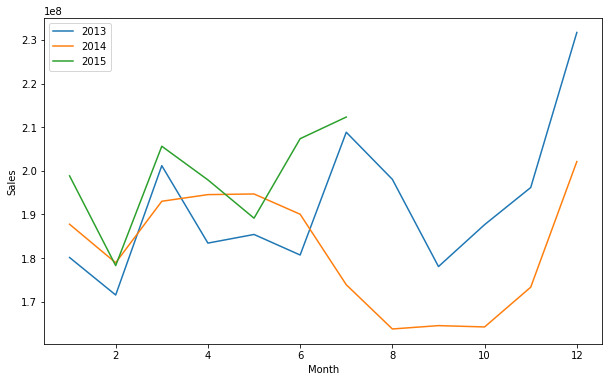

In [184]:
# Sales vs Time graph in terms of years
plt.figure(figsize=(10,6))
for y in set(df.Date.dt.year):
  print(y)
  df_temp = pd.DataFrame(df[df.Date.dt.year==y].groupby(df.Date.dt.month)['Sales'].sum())
  plt.plot(df_temp,label=y)
  plt.legend()
  plt.xlabel("Month")
  plt.ylabel("Sales")

2013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


2014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


2015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


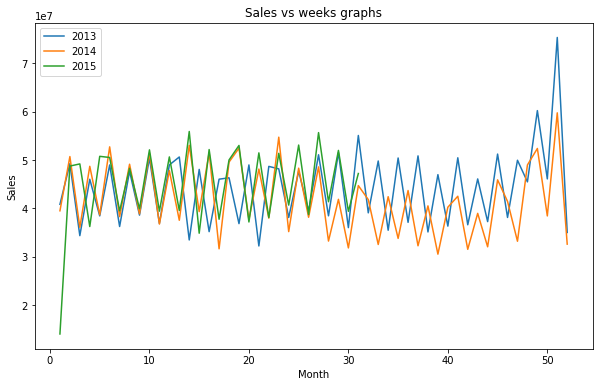

In [185]:
# Sales vs weeks graphs
plt.figure(figsize=(10,6))
for y in set(df.Date.dt.year):
  print(y)
  df_temp = pd.DataFrame(df[df.Date.dt.year==y].groupby(df.Date.dt.week)['Sales'].sum())
  plt.plot(df_temp,label=y)
  plt.legend()
  plt.xlabel("Month")
  plt.ylabel("Sales")
  plt.title('Sales vs weeks graphs')
plt.show()

,Sales
Date,
2013,406974
2014,373855
2015,236380


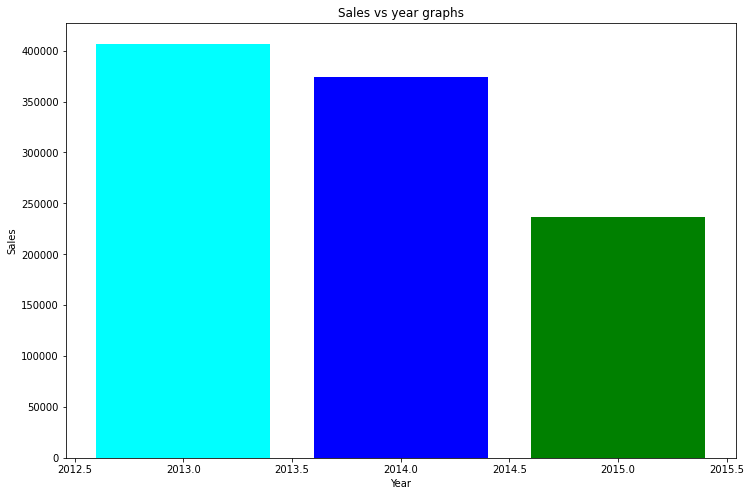

In [186]:
# Checking over all sales for each year
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.Date.dt.year)['Sales'].count())
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title('Sales vs year graphs')

plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'blue', 'green'])
df_temp

<BarContainer object of 7 artists>

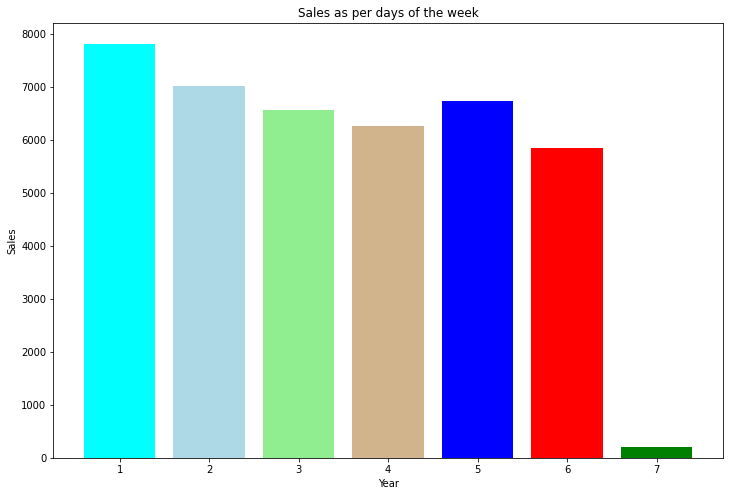

In [187]:
# Sales as per days of the week
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.DayOfWeek)['Sales'].mean())
days = {1:'m',2:'t',3:'w',4:'t',5:'f',6:'s',7:'s'}

plt.xlabel("Year")
plt.ylabel("Sales")
plt.title('Sales as per days of the week')

plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'lightblue', 'lightgreen', 'tan','blue','red','green'])

<BarContainer object of 7 artists>

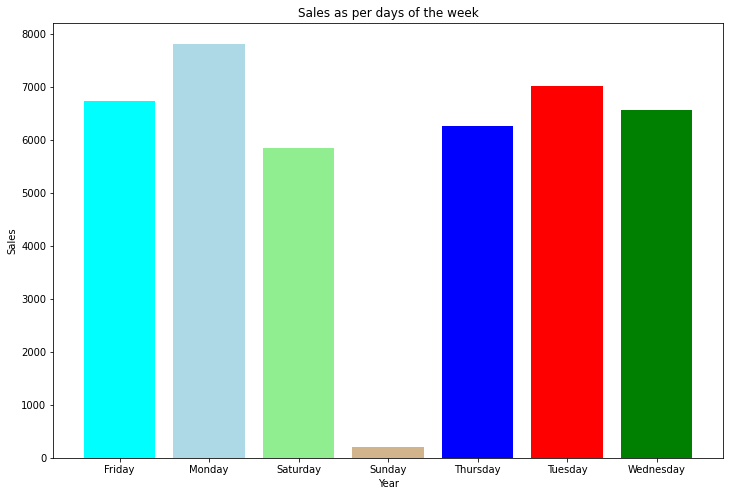

In [188]:
df
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.Date.dt.day_name())['Sales'].mean())
df_temp
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title('Sales as per days of the week')
plt.bar(df_temp.index, df_temp.Sales, color = ['cyan', 'lightblue', 'lightgreen', 'tan','blue','red','green'])


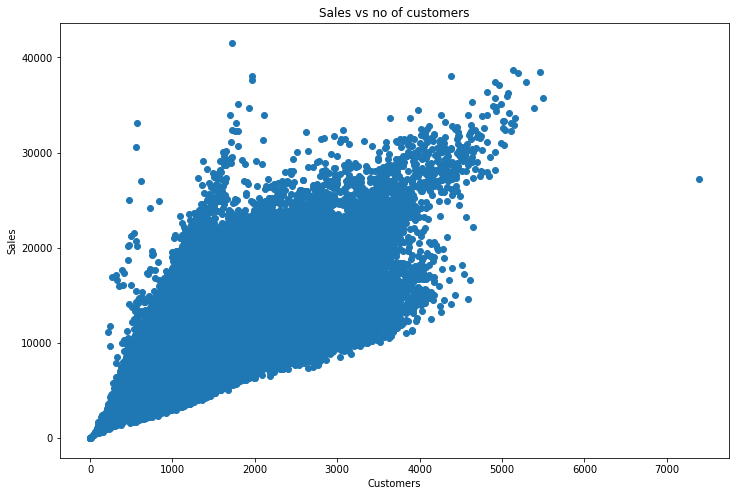

In [189]:
plt.figure(figsize=(12,8))
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title('Sales vs no of customers')
plt.scatter(df.Customers,df.Sales)

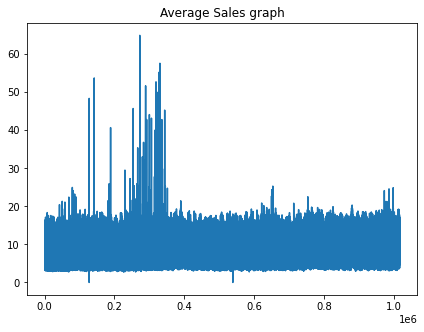

In [190]:
plt.figure(figsize=(7,5))
plt.plot((df.Sales/df.Customers))
'''
plt.ylabel('Average Sales')
plt.xlabel('Customers')
plt.xticks()
'''
plt.title('Average Sales graph')
plt.show()

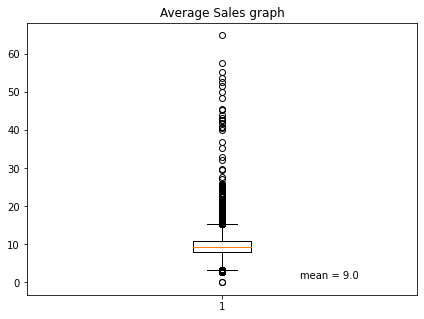

In [191]:
plt.figure(figsize=(7,5))
plt.boxplot((df[df.Customers != 0 ].Sales/df[df.Customers != 0].Customers))
'''
plt.ylabel('Average Sales')
plt.xlabel('Customers')
plt.xticks()
'''
plt.text(1.2,1,'mean = ' + str(round((df[df.Customers != 0 ].Sales/df[df.Customers != 0].Customers).mean(),0)))
plt.title('Average Sales graph')
plt.show()

1    844392
0    172817
Name: Open, dtype: int64
           Sales
Open            
0              0
1     5873180623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


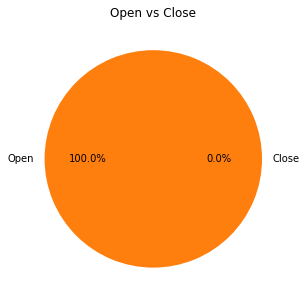

In [192]:

df_temp = pd.DataFrame(df.groupby(df.Open)['Sales'].sum())

print(df.Open.value_counts())
print(df_temp)

plt.figure(figsize=(5,5))
plt.pie(df_temp,autopct='%1.1f%%',labels=['Close', 'Open'])
plt.title('Open vs Close')
plt.show()
#plt.pie(  )

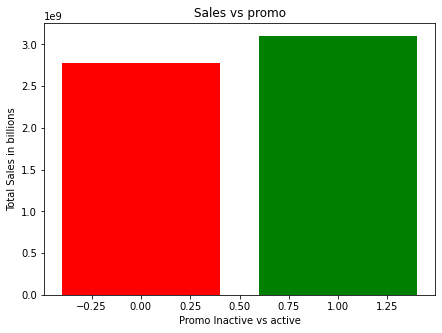

In [193]:
# Difference in sales if the promo was active
plt.figure(figsize=(7,5))
df_temp = pd.DataFrame(df.groupby(df.Promo)['Sales'].sum())
plt.bar(df_temp.index,df_temp.Sales, color =['red','green'])
plt.ylabel('Total Sales in billions')
plt.xlabel('Promo Inactive vs active')
plt.xticks()
plt.title('Sales vs promo')
plt.show()

In [194]:
df.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [195]:
df.StateHoliday = df.StateHoliday.astype('string')


<BarContainer object of 4 artists>

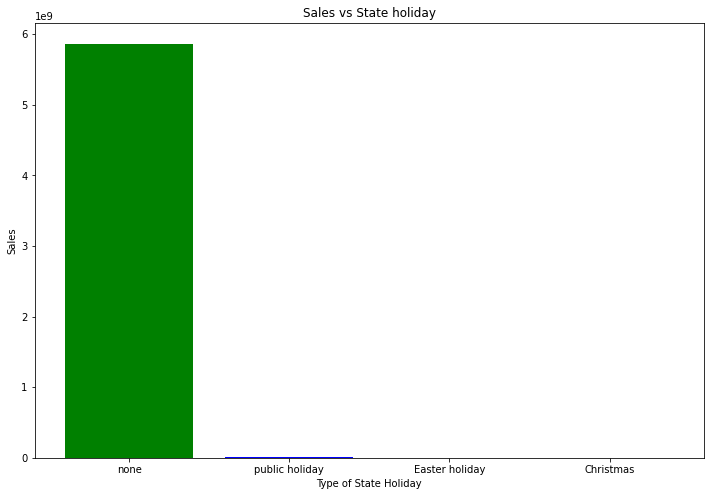

In [196]:
plt.figure(figsize=(12,8))
df_temp = pd.DataFrame(df.groupby(df.StateHoliday)['Sales'].sum())
df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel("Type of State Holiday")
plt.ylabel("Sales")
plt.title('Sales vs State holiday')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

In [197]:
df.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

No handles with labels found to put in legend.


<BarContainer object of 2 artists>

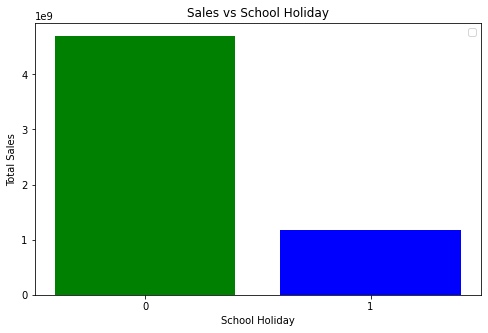

In [198]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.SchoolHoliday)['Sales'].sum())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('School Holiday')
plt.ylabel('Total Sales')
plt.title('Sales vs School Holiday')
plt.legend()
plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue'])#,'cyan','red'])

   StoreType
a     551627
d     312912
c     136840
b      15830


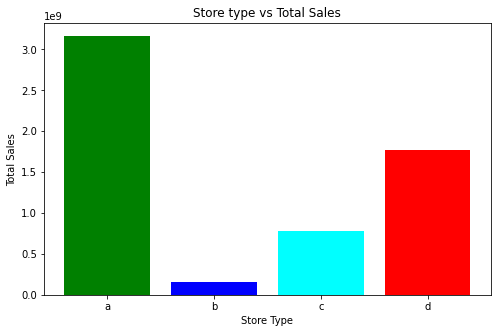

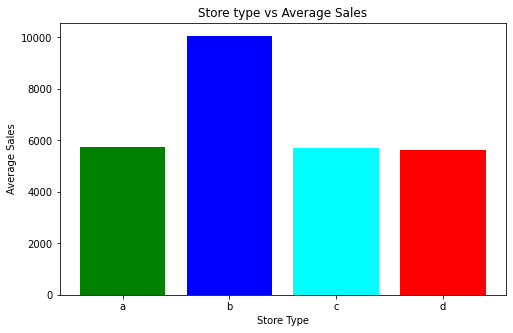

In [199]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.StoreType)['Sales'].sum())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Store type vs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

plt.figure(figsize=(8,5))

df_temp = pd.DataFrame(df.groupby(df.StoreType)['Sales'].mean())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Store type vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])
print(pd.DataFrame(df.StoreType.value_counts()))

   Assortment
a      537445
c      471470
b        8294


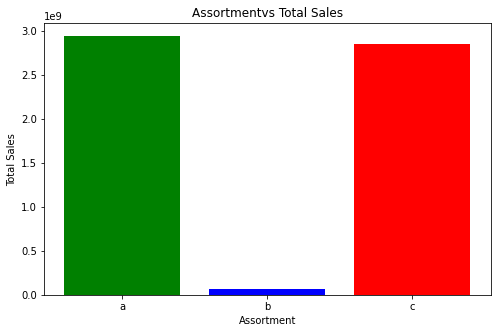

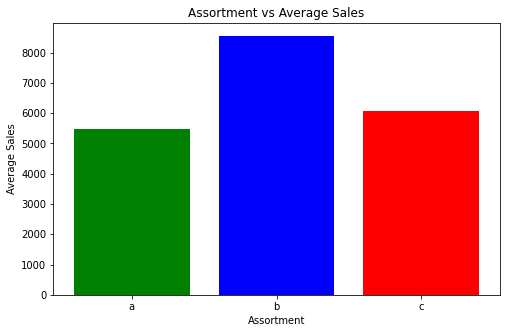

In [200]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Assortment)['Sales'].sum())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Assortment')
plt.ylabel('Total Sales')
plt.title('Assortmentvs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','red'])

plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.Assortment)['Sales'].mean())
df_temp.index = df_temp.index.astype('string')
#df_temp.index = df_temp.index.map({'0':'none','a':'public holiday','b':'Easter holiday','c':'Christmas'})

plt.xlabel('Assortment')
plt.ylabel('Average Sales')
plt.title('Assortment vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','red'])
print(pd.DataFrame(df.Assortment.value_counts()))

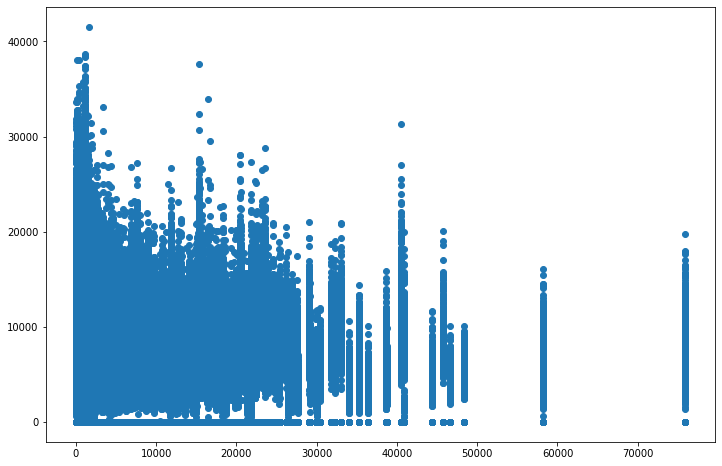

In [201]:
plt.figure(figsize=(12,8))
plt.scatter(df.CompetitionDistance,df.Sales)

None                508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64


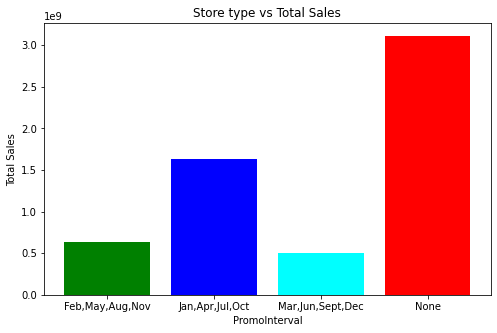

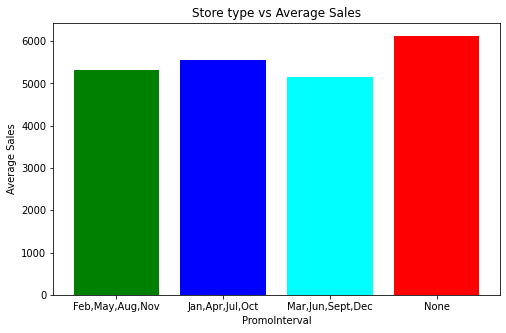

In [202]:
plt.figure(figsize=(8,5))
df_temp = pd.DataFrame(df.groupby(df.PromoInterval)['Sales'].sum())


plt.xlabel('PromoInterval')
plt.ylabel('Total Sales')
plt.title('Store type vs Total Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])

plt.figure(figsize=(8,5))

df_temp = pd.DataFrame(df.groupby(df.PromoInterval)['Sales'].mean())

plt.xlabel('PromoInterval')
plt.ylabel('Average Sales')
plt.title('Store type vs Average Sales')

plt.bar(df_temp.index, df_temp.Sales, color = ['green','blue','cyan','red'])
print(df.PromoInterval.value_counts())

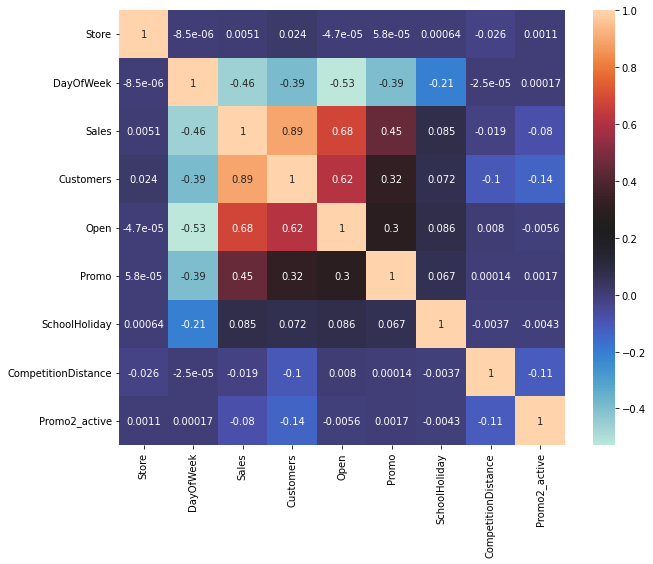

In [203]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),cmap='icefire', annot=True)
plt.show()

# Time Series Analysis

In [204]:
ts = pd.DataFrame(df[['Date','Sales']])
ts

,Date,Sales
0,2013-01-01,0
1,2013-01-01,0
2,2013-01-01,0
3,2013-01-01,0
4,2013-01-01,0
...,...,...
1017204,2015-07-31,9082
1017205,2015-07-31,10708
1017206,2015-07-31,7481
1017207,2015-07-31,10460


In [205]:
ts = df.groupby(['Date'])['Sales'].sum()

ts

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

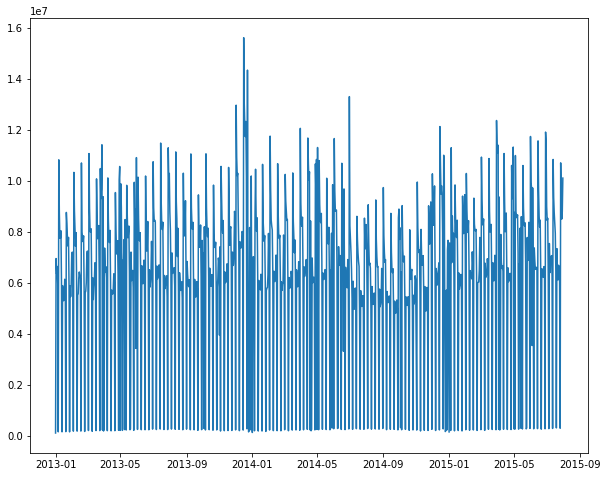

In [206]:
plt.figure(figsize=(10,8))
plt.plot(ts.index, ts)
plt.show()

In [207]:
from statsmodels.tsa.seasonal import  seasonal_decompose

In [208]:
result = seasonal_decompose(ts,model='additive',freq=30)

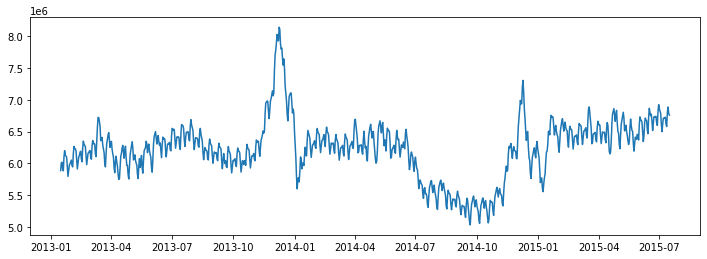

In [209]:

plt.figure(figsize=(12,4))
plt.plot(result.trend)
plt.show()

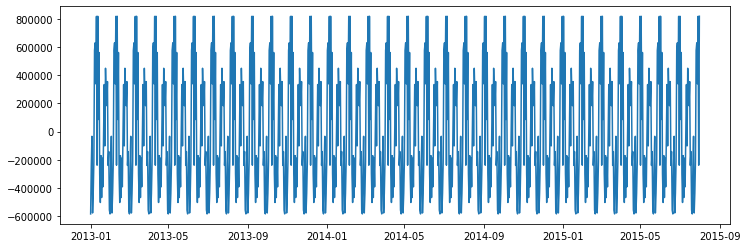

In [210]:

plt.figure(figsize=(12,4))
plt.plot(result.seasonal)
plt.show()

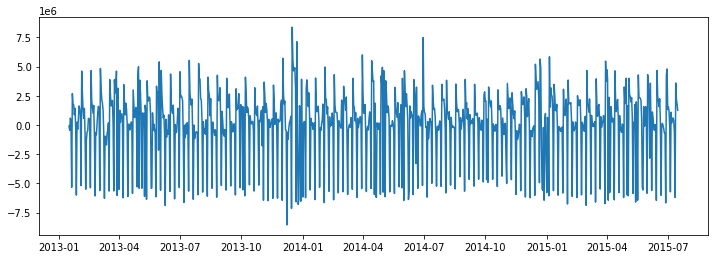

In [211]:

plt.figure(figsize=(12,4))
plt.plot(result.resid)
plt.show()

In [212]:
df[df.Sales == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,None,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,None,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,"Feb,May,Aug,Nov",1
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,None,0
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,"Feb,May,Aug,Nov",1
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,None,0


# Feature Engineering

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


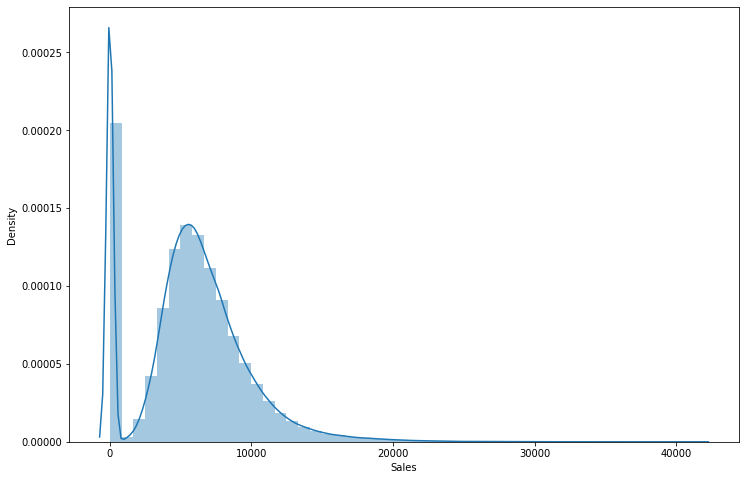

In [213]:
independent_feature = df.Sales
plt.figure(figsize=(12,8))
sns.distplot(independent_feature)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


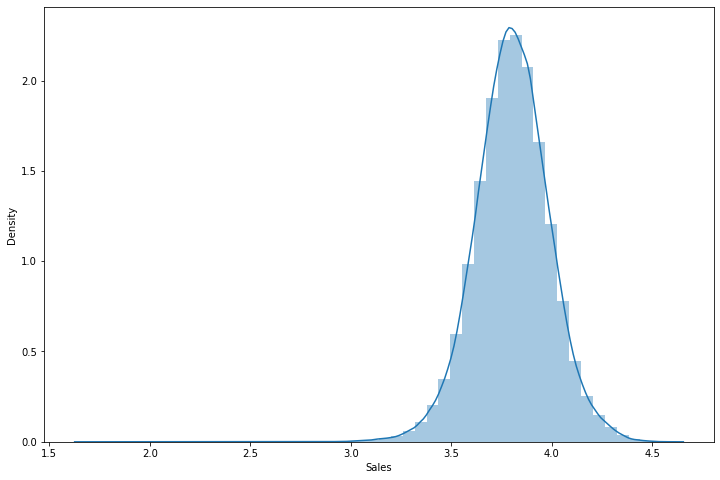

In [214]:
independent_feature1 = df[df.Sales != 0].Sales
plt.figure(figsize=(12,8))
sns.distplot(np.log10(independent_feature1))
plt.show()

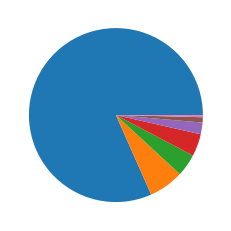

In [215]:
plt.pie(list(df[df.Sales == 0].DayOfWeek.value_counts()))
plt.show()

In [216]:
#dependent_features = ['Store','DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType','PromoInterval' ]

In [217]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  string        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [218]:
df.SchoolHoliday.value_counts()
df.Assortment.value_counts()

a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

In [219]:
# Extracting columns using date

df["month"] = df['Date'].dt.month   # extract month name from Date column
df["day"] = df['Date'].dt.day   # extract month name from Date column
df["year"] = df['Date'].map(lambda x: x.year).astype("string")     # extract year from Date column and convert it in object type
df = df.drop(['Date'],axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   DayOfWeek            1017209 non-null  int64  
 2   Sales                1017209 non-null  int64  
 3   Customers            1017209 non-null  int64  
 4   Open                 1017209 non-null  int64  
 5   Promo                1017209 non-null  int64  
 6   StateHoliday         1017209 non-null  string 
 7   SchoolHoliday        1017209 non-null  int64  
 8   StoreType            1017209 non-null  object 
 9   Assortment           1017209 non-null  object 
 10  CompetitionDistance  1017209 non-null  float64
 11  PromoInterval        1017209 non-null  object 
 12  Promo2_active        1017209 non-null  int64  
 13  month                1017209 non-null  int64  
 14  day                  1017209 non-null  int64  
 15

In [220]:
df.year.value_counts()

2013    406974
2014    373855
2015    236380
Name: year, dtype: Int64

In [221]:
# Label Ecoding
encoders_nums = {"year":{"2013":1,"2014":2,"2015":3}, "Assortment":{"a":1,"b":2,"c":3} }

df = df.replace(encoders_nums)

In [222]:
df.Assortment.value_counts()

1    537445
3    471470
2      8294
Name: Assortment, dtype: int64

In [223]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active,month,day,year
0,1115,2,0,0,0,0,a,1,d,3,5350.0,"Mar,Jun,Sept,Dec",1,1,1,1
1,379,2,0,0,0,0,a,1,d,1,6630.0,None,0,1,1,1
2,378,2,0,0,0,0,a,1,a,3,2140.0,None,0,1,1,1
3,377,2,0,0,0,0,a,1,a,3,100.0,"Feb,May,Aug,Nov",1,1,1,1
4,376,2,0,0,0,0,a,1,a,1,160.0,None,0,1,1,1


In [224]:
# One hot encoding
print(df.StateHoliday.value_counts())
print(df.StoreType.value_counts())
print(df.PromoInterval.value_counts())

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: Int64
a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64
None                508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64


In [225]:
df = pd.get_dummies(df, columns= ["StateHoliday", "StoreType","PromoInterval"])

In [226]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1115,2,0,0,0,0,1,3,5350.0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0
1,379,2,0,0,0,0,1,1,6630.0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1
2,378,2,0,0,0,0,1,3,2140.0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1
3,377,2,0,0,0,0,1,3,100.0,1,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0
4,376,2,0,0,0,0,1,1,160.0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,1


In [227]:
df.drop(columns= ['StateHoliday_0','StoreType_b', 'PromoInterval_None'],inplace = True)

In [228]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1115,2,0,0,0,0,1,3,5350.0,1,1,1,1,1,0,0,0,0,1,0,0,1
1,379,2,0,0,0,0,1,1,6630.0,0,1,1,1,1,0,0,0,0,1,0,0,0
2,378,2,0,0,0,0,1,3,2140.0,0,1,1,1,1,0,0,1,0,0,0,0,0
3,377,2,0,0,0,0,1,3,100.0,1,1,1,1,1,0,0,1,0,0,1,0,0
4,376,2,0,0,0,0,1,1,160.0,0,1,1,1,1,0,0,1,0,0,0,0,0


In [229]:
df.shape

(1017209, 22)

 # Modelling

In [230]:
independent_features = ['DayOfWeek','Customers','Open','Promo','SchoolHoliday','Assortment','CompetitionDistance','Promo2_active','month','day','year','StateHoliday_a','StateHoliday_b',
        'StateHoliday_c', 'StoreType_a','StoreType_c','StoreType_d','PromoInterval_Feb,May,Aug,Nov','PromoInterval_Jan,Apr,Jul,Oct','PromoInterval_Mar,Jun,Sept,Dec']
dependent_features = ['Sales']

In [231]:
#df = df[df.Sales!=0]

In [232]:
X = df[independent_features]
X

,DayOfWeek,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2_active,month,day,year,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_c,StoreType_d,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,2,0,0,0,1,3,5350.0,1,1,1,1,1,0,0,0,0,1,0,0,1
1,2,0,0,0,1,1,6630.0,0,1,1,1,1,0,0,0,0,1,0,0,0
2,2,0,0,0,1,3,2140.0,0,1,1,1,1,0,0,1,0,0,0,0,0
3,2,0,0,0,1,3,100.0,1,1,1,1,1,0,0,1,0,0,1,0,0
4,2,0,0,0,1,1,160.0,0,1,1,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,5,638,1,1,1,3,4330.0,1,7,31,3,0,0,0,0,0,1,0,0,1
1017205,5,826,1,1,1,3,45740.0,0,7,31,3,0,0,0,0,1,0,0,0,0
1017206,5,578,1,1,1,1,2380.0,1,7,31,3,0,0,0,0,0,1,0,1,0
1017207,5,1016,1,1,1,3,4380.0,0,7,31,3,0,0,0,0,0,1,0,0,0


In [233]:
#y = np.log10(df[dependent_features]+0.000000001)
#y = np.log10(df[dependent_features])
y = df[dependent_features]

y

,Sales
0,0
1,0
2,0
3,0
4,0
...,...
1017204,9082
1017205,10708
1017206,7481
1017207,10460


In [234]:
from sklearn.model_selection import train_test_split

In [235]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## Linear Regression

In [236]:
  from sklearn.linear_model import LinearRegression

In [237]:
Linear_reg = LinearRegression()
Linear_reg.fit(X_train,y_train)

LinearRegression()

In [238]:
Linear_reg.coef_

array([[-4.86805772e+01,  7.23459024e+00,  8.64917034e+02,
         1.12030209e+03,  3.19345557e+01,  1.24198027e+02,
         2.06641179e-02, -1.17784678e+02,  3.13213870e+01,
         1.00377207e+00,  1.52632145e+02, -5.75899010e+02,
        -7.36054088e+02, -2.75946352e+02,  5.29569943e+03,
         5.19662472e+03,  6.22529191e+03,  3.05521413e+02,
         3.75116295e+02,  1.50760393e+02]])

In [239]:
Linear_reg.score(X_train,y_train)

0.8958710273750098

In [240]:
y_pred = Linear_reg.predict(X_test)

In [241]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [242]:
# Evalute Linear Regression model

MSE  = mean_squared_error(y_test, y_pred)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1546140.381735115
MAE : 882.0898161854766
RMSE : 1243.4389336574254
R2 : 0.8953791930277865
Adjusted R2 :  0.8953689068914512


Text(0, 0.5, 'Predicted Sales')

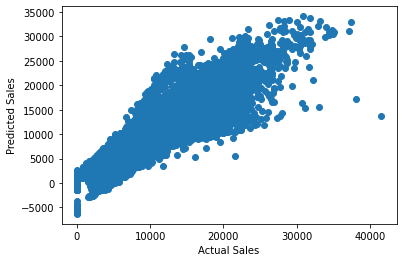

In [243]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

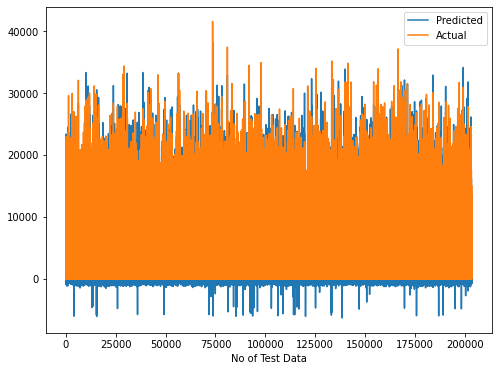

In [244]:
plt.figure(figsize=(8,6))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Analysis')

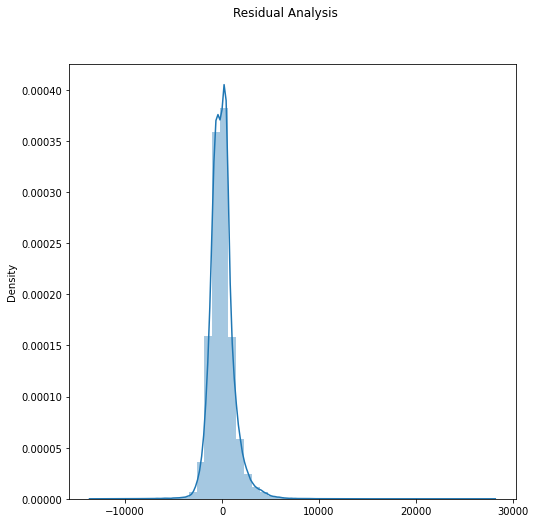

In [245]:
fig=plt.figure(figsize=(8,8))
  
sns.distplot(y_test- y_pred,bins=50)

fig.suptitle('Residual Analysis')   

## Lasso Regression

In [246]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.005,max_iter=3000)

In [247]:
lasso.fit(X_train,y_train)

Lasso(alpha=0.005, max_iter=3000)

In [248]:
lasso.score(X_train,y_train)

0.8958710248662582

In [249]:
y_pred_lasso = lasso.predict(X_test)

In [250]:
# Evalute the model

MSE  = mean_squared_error(y_test, y_pred_lasso)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lasso)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1546139.0333960997
MAE : 882.0878258192645
RMSE : 1243.4383914758703
R2 : 0.8953792842642081
Adjusted R2 :  0.8953689981368431


In [251]:
from sklearn.model_selection import GridSearchCV


In [252]:
### Cross validation
'''lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=4)
lasso_regressor.fit(X_train, y_train)
'''

"lasso = Lasso()\nparameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}\nlasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=4)\nlasso_regressor.fit(X_train, y_train)\n"

In [253]:
#print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
#print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

In [254]:
#y_pred_lasso = lasso_regressor.predict(X_test)

In [255]:
'''MSE  = mean_squared_error(y_test, y_pred_lasso)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lasso)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))
'''

'MSE  = mean_squared_error(y_test, y_pred_lasso)\nprint("MSE :" , MSE)\n\nMAE=mean_absolute_error(y_test, y_pred_lasso)\nprint("MAE :" ,MAE)\n\nRMSE = np.sqrt(MSE)\nprint("RMSE :" ,RMSE)\n\nr2 = r2_score(y_test, y_pred_lasso)\nprint("R2 :" ,r2)\nprint("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))\n'

## Ridge Regression

In [256]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)

In [257]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1)

In [258]:
ridge.score(X_train, y_train)

0.8958710273516491

In [259]:
y_pred_ridge = ridge.predict(X_test)

In [260]:
MSE  = mean_squared_error(y_test, y_pred_ridge)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_ridge)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1546140.3011327675
MAE : 882.0896800263245
RMSE : 1243.438901246365
R2 : 0.8953791984818078
Adjusted R2 :  0.8953689123460088


Text(0, 0.5, 'Predicted Sales')

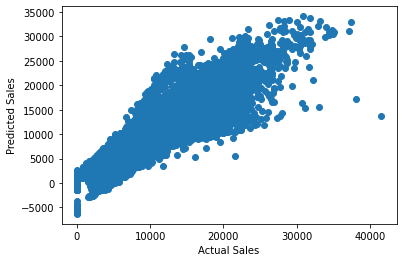

In [261]:
plt.scatter(y_test, y_pred_ridge)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

## XG Boost Regressor

In [274]:
from xgboost import XGBRegressor 

xgbr = XGBRegressor()

In [275]:
xgbr.fit(X_train,y_train)

[15:10:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [276]:
xgbr.score(X_train, y_train)

0.9349502636935867

In [277]:
y_pred_xgbr = xgbr.predict(X_test)

In [278]:
MSE  = mean_squared_error(y_test, y_pred_xgbr)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr)
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_xgbr))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 971879.0039474919
MAE : 680.7943103763495
RMSE : 985.8392383890448
R2 : 0.9342370415561934
Adjusted R2 :  0.9342305758561482


In [265]:
#Cross Validation with Grid Search CV
'''
xgbr = XGBRegressor()
parameters = {}
xgbr_regressor = GridSearchCV(xgbr,parameters, scoring='neg_mean_squared_error', cv=5)
xgbr_regressor.fit(X_train, y_train)
'''

[15:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), param_grid={},
             scoring='neg_mean_squared_error')

In [266]:
#xgbr_regressor.best_score_

-972083.5877619751

In [267]:
#xgbr_regressor.score(X_train, y_train)

-964866.7661247053

In [268]:
# Cross Validation with cross_val_score and KFold
'''
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=4, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average scores :", kf_cv_scores)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
'''

[15:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
K-fold CV average score: 0.93
